In [17]:
import random as rd
import numpy as np
import matplotlib.pyplot as plot

18
18
14
28
5
32
25
12
11
15
3
30
10
2
33
36
34
34
1
26
25
31
25
21
27
26
0
22
27
20
8
29
16
11
23
31
22
31
22
31
34
28
12
2
30
2
14
29
37
6
17
27
19
4
19
8
12
29
21
20
24
13
6
18
1
20
20
9
2
12
9
12
33
10
23
20
11
11
28
24
21
17
29
12
23
15
14
1
8
24
13
7
2
23
17
27
31
10
7
4
30
1
6
11
31
4
24
12
28
13
34
6
31
14
6
19
26
15
3
5
28
13
26
4
13
16
17
8
23
19
27
14
28
25
24
6
14
3
8
22
5
18
14
24
26
33
4
27
29
19
8
3
7
17
1
25
16
20
12
1
20
28
16
32
3
20
12
19
13
14
34
14
14
23
33
23
7
23
29
3
26
1
10
4
21
9
29
28
34
21
3
31
23
10
5
7
34
4
29
29
11
13
4
25
22
34
10
2
20
28
14
11
18
20
24
5
21
7
28
18
23
30
16
30
11
8
19
26
19
9
15
1
23
22
11
6
26
3
32
20
34
18
13
12
3
16
32
33
2
2
2
11
31
21
29
33
17
1
17
15
11
9
6
27
4
22
8
17
31
10
2
31
22
24
0
7
27
26
17
13
6
6
3
26
33
2
17
23
9
25
23
27
16
12
20
12
31
20
24
13
8
6
20
5
24
29
20
9
16
19
15
19
20
6
21
10
6
31
8
28
2
2
31
15
14
7
32
18
3
10
5
9
26
13
11
33
3
21
27
28
9
25
1
19
3
17
26
16
21
31
11
30
21
24
23
25
25
14
2
16
25
34
17
4
29
2

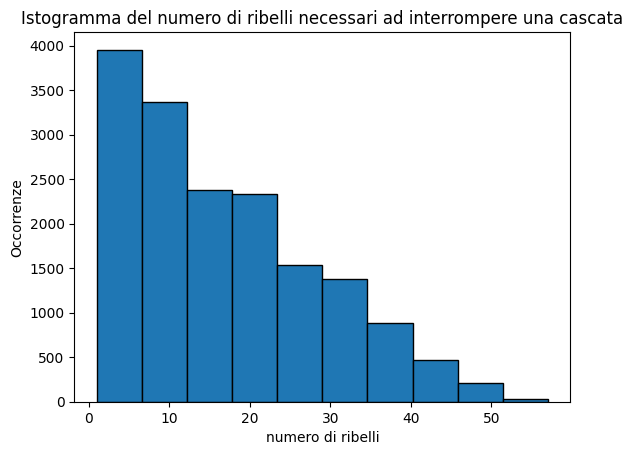

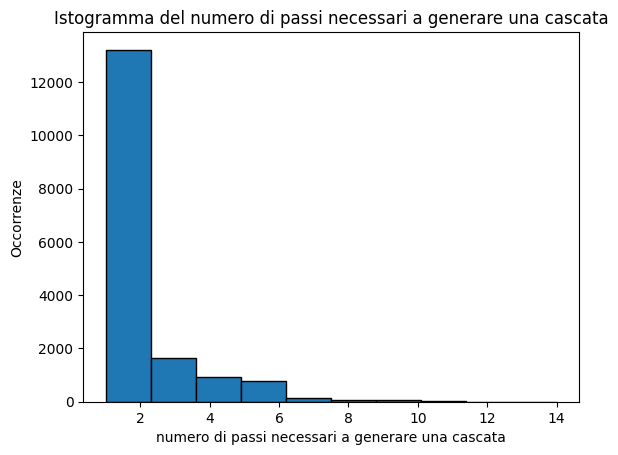

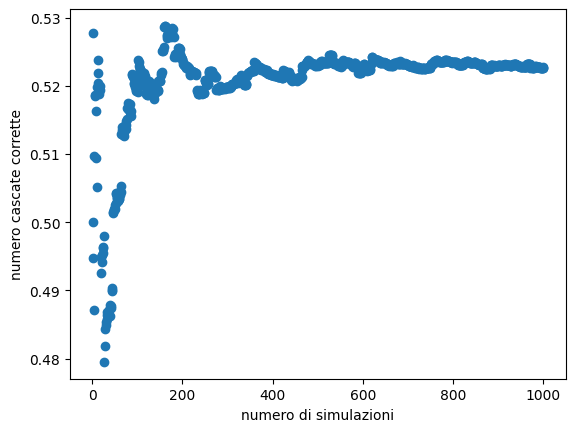

In [22]:
priorblue = 0.5
priorred = 0.5
blue = 0
red = 1
#q è la prob che dato lo stato good si abbia un high signal e dato lo stato bad si abbia un low signal (prob che la pallina sia rossa se l'urna è a maggioranza rossa e blu se è a maggioranza blu)
q = 2/3
    
#definisce in modo casuale lo stato dell'universo (maggioranza rossa, maggioranza blu)
def universe():
    state = rd.randint(0,1)
    return state

#definisce il numero di partecipanti all'esperimento
def partecipants():
    num = rd.randint(3,100)
    return num

#riempie un vettore con la corretta proporzione di palline a seconda dello stato dell'universo
def vector_world(state):
    alternative = [0,1]
    if state == 1:
        world = [1,1,0]
    else:
        world = [0,0,1]
    return world

#effettua l'estrazione della pallina dall'urna
def extraction(world):
    signal = rd.choice(world)
    return signal

#calcola la probabilità che data una serie di segnali, l'urna sia a maggioranza rossa o blu
def bayes(p, a , b , q):
    denom = ( p * (q**a) * ((1-q)**b) + (1-p) * ((1-q)**a) * (q**b) )
    if denom == 0:
        denom = np.nextafter(0, 1)
    post = ( p * (q**a) * ((1-q)**b) )/ denom
    return post

#effettua la scelta in base alle posterior
def make_decision(postblue, postred, signal):
    if postblue > postred:
        choice = 0
    elif postblue < postred:
        choice = 1 
    else:
        choice = signal
    return choice

#verifica se due giocatori compiono consecutivamente la stessa scelta dando quindi origine ad una cascata\n",
def controller(vector,i):
    if len(vector) == 1:   
        return None
    else:
        if vector[i] == vector[i - 1]:
            return False
        return True


#dinamica per un partecipante
def singlepartecipant(a, b, q, state, world, correct_signal, count_coherent, count_incoherent):
    
    signal = extraction(world)
    if signal == state:
        correct_signal += 1
    if signal == 1:
        a += 1
    else:
        b += 1
    
    postred = bayes(priorred, a, b, q)
    postblue = 1 - postred
   
    choice = make_decision(postblue, postred, signal)
    if signal == choice:
        count_coherent += 1
        return a, b, choice, count_coherent, count_incoherent, correct_signal, postblue, postred, signal

    else:
        if signal == 1: 
            a -= 1
            b += 1
        else:
            a += 1
            b -= 1        
        count_incoherent += 1     
        return a, b, choice, count_coherent, count_incoherent, correct_signal, postblue, postred, signal

#il ribelle sceglie la scelta minoritaria
def rebel(a, b, var, state, correct_signal, count_coherent, count_incoherent, q):
    
    choice = var
    signal = extraction(world)

    if choice == state:
        correct_signal += 1

    if choice == 1:
        a += 1
    else:
        b += 1
        
    if choice == signal:
        count_coherent += 1
    else:
        count_incoherent += 1
    
    postred = bayes(priorred, a, b, q)
    postblue = 1 - postred

    return a, b, choice, count_coherent, count_incoherent,correct_signal, postblue, postred

#vettore che raccoglie il numero di volte in cui la scelta = segnale ad ogni esperimento
vector_coherent = []

#vettore che raccoglie il numero di volte in cui la scelta è diversa dal segnale ad ogni esperimento
vector_incoherent = []

#vettore che raccoglie il numero di volte che la cascata porta alla soluzione corretta
correct_guesses = []

#vettore che raccoglie il numero di partecipanti per ogni simulazione
vector_participants = []

#vettore che raccoglie in ogni simulazione il numero di passi necessari a dare avvio ad una cascata
counter = []

#vettore che raccoglie in ogni simulazione il numero di ribelli necessari a interrompere la cascata
vect_rebel = []
    
#vettore che raccoglie l'indice di ogni simulazione
vector_sim = []

#contatore per numero di volte in cui la cascata porta ad un risultato corretto
num_correct_cascade = 0

num_sim = 1000

correct_cascade_rate = 0
correct_guesses_rate = []

#faccio num_sim simulazioni
for j in range(0,num_sim):

    #estraggo casualmente il numero di partecipanti dell'esperimento
    numpart = partecipants()

    #vettore con i numeri da 0 a numpart
    vector_part = []

    #vettore che raccoglie i segnali
    signal_vect = []

    #vettore che raccoglie il numero di partecipanti ad ogni simulazione
    vector_participants.append(numpart)

    #creo lo stato dell'universo
    state = universe()

    #creo il vettore che contiene la giusta proporzione di palline
    world = vector_world(state)

    #calcolo la probabilità di estrarre una pallina rossa condizionata allo stato dell'universo
    q = 2/3
    
    #inizializzo contatore segnale rosso
    a = 0

    #inizializzo contatore segnale blu
    b = 0

    #vettore delle scelte
    choice = []

    #numero di volte in cui il segnale e la scelta corrispondono
    count_coherent = 0

    #numero di volte in cui il segnale e la scelta non corrispondono
    count_incoherent = 0

    #parametro di controllo per la cascata
    control = True
    i = 1
    
    #conta il numero di cascate per ogni simulazione
    counter_cascade_single_simulation = 0
    #conta il numero di passi necessari per innescare una cascata, ad ogni simulazione si resetta. Si utilizza poi per fare una media dividendo per il numero di volte che si è verificata in quella simulazione una cascata. Poi si aggiunge al vettore che tiene conto di tutte le simulazioni il risultato.
    counter_steps_single_simulation = 0
    #conta il numero di cascate corrette per ogni simulazione
    num_correct_cascade = 0
    
    diff = 0 
    num_rebel = 0
    correct_signal = 0
    
    #eseguo la funzione su ogni partecipante all'esperimento
    while i <= numpart:
        
        #se non si è verificata la cascata
        if control == True:
            a, b, single_choice, count_coherent, count_incoherent, correct_signal, postblue, postred, signal = singlepartecipant(a, b, q, state, world, correct_signal, count_coherent, count_incoherent)
            vector_part.append(i)
            choice.append(single_choice)
            signal_vect.append(signal)
           #verifico se due partecipanti consecutivi abbiano fatto la stessa scelta
            if controller(choice,i-1) == False:
                control = False
                #aggiungo al vettore il numero di passi che ci sono voluti per avviare la cascata
                counter.append(i-diff)
                counter_cascade_single_simulation += 1 
                #verifico se la cascata è corretta
                if ((choice[i-1] == 0 and state == 0) or (choice[i-1] == 1 and state == 1)):
                    num_correct_cascade += 1
       
        #se si è verificata la cascata
        else:
            if postblue > postred:
                while postblue > postred:
                    num_rebel += 1
                    a, b, signal, count_coherent, count_incoherent, correct_signal, postblue, postred = rebel(a,b,1,state,correct_signal,count_coherent,count_incoherent,q)
                    vector_part.append(i)
                    choice.append(signal)
                    signal_vect.append(signal)
                    control = True 
                    #print(a,b,"segnale",signal,"scelta",signal,"postred",postred,"postblue",postblue,"numero passi",counter_steps_single_simulation,"numero di cascate",counter_cascade_single_simulation,control)
            elif postred > postblue:
                while postred > postblue:
                    num_rebel += 1
                    a, b, signal, count_coherent, count_incoherent, correct_signal, postblue, postred = rebel(a,b,0,state,correct_signal,count_coherent,count_incoherent,q)
                    vector_part.append(i)
                    choice.append(signal)
                    signal_vect.append(signal)
                    control = True 
                    #print(a,b,"segnale",signal,"scelta",signal,"postred",postred,"postblue",postblue,"numero passi",counter_steps_single_simulation,"numero di cascate",counter_cascade_single_simulation,control)
            vect_rebel.append(num_rebel)
            diff = i
            control = True
        i += 1 
    if counter_cascade_single_simulation == 0:
        counter_cascade_single_simulation = 1
        
    correct_cascade_rate += num_correct_cascade/counter_cascade_single_simulation
                  
    #vettore che contiene il rate di correttezza della cascata dopo (j+1) simulazioni
    correct_guesses.append(correct_cascade_rate/(j+1))
    #vettore che contiene il numero della simulazione
    vector_sim.append(j+1)
    
    vector_coherent.append(count_coherent)
    vector_incoherent.append(count_incoherent)

#calcolo media
media_passi = np.mean(counter) 
print("media passi",media_passi)   

media_ribelli = np.mean(vect_rebel)
print("media ribelli",media_ribelli)

plot.hist(vect_rebel, bins=10, edgecolor='black')
plot.title("Istogramma del numero di ribelli necessari ad interrompere una cascata")
plot.xlabel("numero di ribelli")
plot.ylabel("Occorrenze")
plot.show()

plot.hist(counter, bins=10, edgecolor='black')
plot.title("Istogramma del numero di passi necessari a generare una cascata")
plot.xlabel("numero di passi necessari a generare una cascata")
plot.ylabel("Occorrenze")
plot.show()

plot.scatter(vector_sim, correct_guesses)
plot.xlabel('numero di simulazioni')
plot.ylabel('numero cascate corrette')
plot.show()
